# AGN Selection Model Walkthrough

This interactive Python notebook demonstrates a simple model of variability-selection of AGN in optical surveys.

## Model Priors:

• Survey Cadence: Number of seasons, photometric epochs per season, seperation/epoch; or arbitrary sequence of times.

• Observation Model: Photometric error level.

• Universe: Galaxy redshift, stellar mass, and magnitude distributions from COSMOS database. Specify occupation fraction.

• AGN/QSO variability model: Specify structure function.




In [514]:
import qso_fit as qso_fit
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
import astropy.constants as const
from astropy.io import fits
from astropy.cosmology import FlatLambdaCDM, z_at_value

cosmo = FlatLambdaCDM(H0=70, Om0=0.3, Tcmb0=2.725)

%matplotlib inline
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['mathtext.fontset'] = "custom"
plt.rcParams["mathtext.rm"] =  "Times New Roman"
plt.rcParams["mathtext.it"] =  "Times New Roman"
plt.rcParams["mathtext.bf"] =  "Times New Roman"
plt.rcParams.update({'font.size': 14})

NSA_PATH = "nsa_v1_0_1.fits"

## Mock Light Curve Generator

Generate a mock damped random walk (DRW) light curve, adapted from ```astroML.time_series.generate_damped_RW```. Following Kelly et al. (2009), the flux $X$ follows the DRW (Ornstein–Uhlenbeck process) is:

$$ dX(t) = -X(t)dt + \sqrt2 \text{SF}_\infty \epsilon(t) \sqrt{dt} + \bar{X}dt$$

where the structure function is $\text{SF}=\sigma \sqrt{\tau} \sqrt{1-e^{t/\tau}}$. Therefore, $\text{SF}_\infty = \sigma\sqrt{\tau}$.

In [51]:
def mock_drw(t_rest, tau=300., z=2.0, xmean=0, SFinf=0.3):
    
    N = len(t_rest)
    
    t_obs = t_rest * (1. + z) / tau

    x = np.zeros(N)
    x[0] = np.random.normal(xmean, SFinf)
    E = np.random.normal(0, 1, N)

    for i in range(1, N):
        dt = t_obs[i] - t_obs[i - 1]
        x[i] = (x[i - 1]
                - dt * (x[i - 1] - xmean)
                + np.sqrt(2) * SFinf * E[i] * np.sqrt(dt))
        
    return x

## Define Cadence

Generate an array of times (days) given a number of seasons, epochs per season, and typical seperation per epoch in days. Defaults to DES.

In [550]:
def t_cadence(seasons=6,epochs_per_season=3,sep_per_epoch=1):
    t_days = range(365*seasons)
    t_cadence = []
    for s in range(seasons):
        t_cadence.append(t_days[365*s:epochs_per_season+365*s:sep_per_epoch])
    return np.array(t_cadence).flatten()

## Generate Ensemle of Light Curves

Generate ensemble of DRW light curves given a certain survey cadence and fit light curves using ```qso_fit``` code.

We assume AGNs are "ideal", that is have the exact statistics ```qso_fit``` is looking for. How does the structure function depend on stellar mass?

In [601]:
def ensemble(t_cadence,mag_lim=25,num_objects=100000,distribution="nsa",frac_agn=.1,error_level=0.001):
    
    a1 = -4.10; a2 = 0.14; a3 = 2.92; a4 = -0.07 # g-band structure function parameters
    qso = []; var = []; not_qso = []; mags = [] # initialize output arrays

    print("Generating universe from %s-like distribution." % distribution)
    
    # Which distribution of galaxies to use
    if distribution.lower() == "toy":
        # toy universe
        absolute_mags = np.random.normal(-19.8,1.34,num_objects)
        d = np.random.uniform(0,8500,num_objects)*u.Mpc
        redshifts = [z_at_value(cosmo.comoving_distance,d_i) for d_i in d]
        stellar_masses = np.random.normal(10,1,num_objects)
        # convert to apparent magnitudes
        apparent_mags = absolute_mags + 5*np.log10(d.to(u.pc)/u.pc) - 5
        fluxes = 10**(-0.4*(apparent_mags - 22.5))
    elif distribution.lower() == "nsa":
        # Nasa Sloan Atlas (NSA) of galaxies
        nsa_fits = fits.open(NSA_PATH)
        obj_nsa = nsa_fits[1].data
        #np.random.shuffle(obj_nsa) # shuffle
        redshifts = obj_nsa["Z"]
        stellar_masses = obj_nsa["ELPETRO_MASS"]
        fluxes = np.array([f[3] for f in obj_nsa["PETRO_FLUX"]]) #  SDSS-style Petrosian flux
        # good fluxes
        where_pos = fluxes > 0
        fluxes = fluxes[where_pos]
        redshifts = redshifts[where_pos]
        stellar_masses = stellar_masses[where_pos]
        # good stellar masses
        where_pos = stellar_masses > 0
        fluxes = fluxes[where_pos]
        redshifts = redshifts[where_pos]
        stellar_masses = stellar_masses[where_pos]
        # convert to apparent magnitudes (nanomaggies to mag)
        apparent_mags = 22.5 - 2.5*np.log10(fluxes)
        # clip size
        num_nsa = len(redshifts)
        if num_objects > num_nsa:
            print("Warning: Clipping number of objects to %d." % num_nsa)
            num_objects = num_nsa
        else:
            apparent_mags = apparent_mags[:num_objects]
            redshifts = redshifts[:num_objects]
            stellar_masses = np.log10(stellar_masses[:num_objects])
    elif distribution.lower() == "cosmos":
        # TODO: Add COSMOS Database
        pass
    
    # Plot objects
    print("Plotting catalog distributions.")
    fig,ax = plt.subplots(1,3,figsize=(12,3))
    ax[0].hist(apparent_mags);
    ax[0].set_xlabel("Magnitude $g$",fontsize=18)
    ax[0].set_ylabel("Number",fontsize=18)
    ax[1].hist(redshifts);
    ax[1].set_xlabel("Redshift $z$",fontsize=18)
    ax[2].hist(stellar_masses);
    ax[2].set_xlabel("Stellar Mass $\log(M_*)$",fontsize=18)
    print("Generating %d light curves." % num_objects)
    
    random_agn_index = np.random.randint(0,frac_agn*num_objects)
    
    # Generate ensemble of objects
    for i in range(num_objects):
        
        return_model = 0
        m = apparent_mags[i]
        flux = fluxes[i]
        
        # AGN
        if i < frac_agn*num_objects:
            z = redshifts[i]
            # Definitions from Butler and Bloom (2011)
            sigma_hat = np.sqrt(10**(a1+a2*(m-19)))
            tau = 10**(a3+a4*(m-19))
            SFinf = sigma_hat*tau**0.5
            # Generate mock damped random walk light curve
            mag = mock_drw(t_rest=t_cadence,tau=tau,z=z,xmean=m,SFinf=SFinf)
            # Add random photometric errors
            mag += np.random.normal(0,error_level,len(t_cadence))
            if i == random_agn_index:
                # Return model for plotting
                return_model = 1
        # non-AGN
        else:
            mag = np.random.normal(m,error_level*m,len(t_cadence))
            
        # Fit mock light curve using qso_fit
        mag_err = error_level*mag
        fit = qso_fit.qso_fit(t_cadence,mag,mag_err,filter='g',sys_err=0,return_model=return_model)
        qso.append(fit["signif_qso"])
        var.append(fit["signif_vary"])
        not_qso.append(fit["signif_not_qso"])
        mags.append(m)
        
        # Plot random AGN light curve example
        if i == random_agn_index:
            print("Plotting example AGN light curve.")
            fig,ax = plt.subplots(1,1,figsize=(12,3))
            ax.fill_between(t_cadence,fit["model"]+fit["dmodel"],fit["model"]-fit["dmodel"])
            ax.errorbar(t_cadence,mag,yerr=mag_err,color='k')
            ax.plot(t_cadence,fit["model"],color='r')
            ax.set_xlabel("Time (days)",fontsize=18)
            ax.set_ylabel("Magnitude $g$",fontsize=18)
            ax.invert_yaxis()
        
    # Truth array
    agn = np.full(num_objects,False)
    agn[:int(frac_agn*num_objects)] = True
            
    return np.array(qso), np.array(var), np.array(not_qso), np.array(stellar_masses), np.array(agn)

## Initialize Model

Generate the survey cadence and ensemble light curves using the methods above.

Generating universe from nsa-like distribution.


/opt/local/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in greater
/opt/local/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in greater


Plotting catalog distributions.
Generating 100000 light curves.
Plotting example AGN light curve.


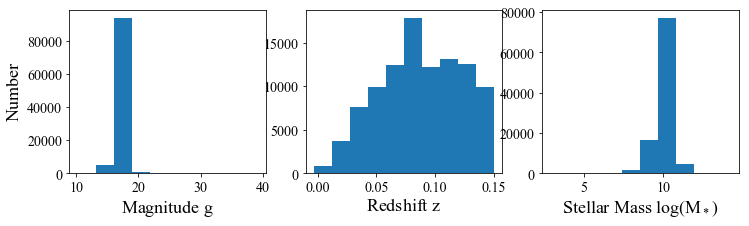

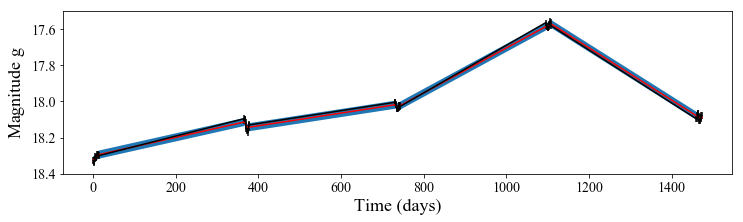

In [607]:
cadence_DES = t_cadence(6,3,1) # DES
cadence_DESSN = t_cadence(5,14,1) # DES Supernova
cadence_LSST = t_cadence(1,120,2) # LSST

qso_DESSN, var_DESSN, not_qso_DESSN, stellar_mass_DESSN, agn_DESSN = ensemble(cadence_DESSN,distribution="nsa")

## Analyze Selection

Plot $\sigma_{var}$ vs. $\sigma_{QSO}$ variability metrics.

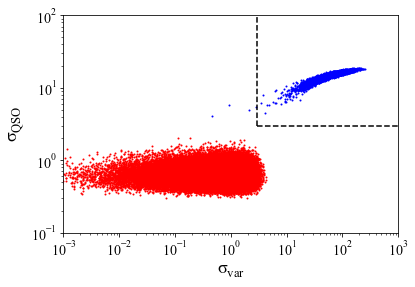

In [612]:
# Plot variability metrics
def plot_metrics(var,qso,title=None):
    fig,ax = plt.subplots(1,1)
    ax.scatter(var[agn==True],qso[agn==True],color="blue",s=1,label="True AGN")
    ax.scatter(var[agn==False],qso[agn==False],color="red",s=1,label="True Galaxy")
    ax.hlines(3,3,10**4,linestyle="dashed")
    ax.vlines(3,3,10**4,linestyle="dashed")
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_ylim(10**-1,10**2)
    ax.set_xlim(10**-3,10**3)
    ax.set_ylabel("$\sigma_{QSO}$",fontsize=18)
    ax.set_xlabel("$\sigma_{var}$",fontsize=18);
    ax.set_title(title)

plot_metrics(var_DESSN,qso_DESSN)

 Plot the detection fraction versus redshift and stellar mass. Any deviation from the initial AGN occupation fraction ```frac_agn``` value set represents the selection bias.

[0.25, 0.1111111111111111, 0.03571428571428571, 0.1171875, 0.10153256704980843, 0.0929553473658596, 0.10215584415584415, 0.08963056255247691, 0.03508771929824561, 0.0]


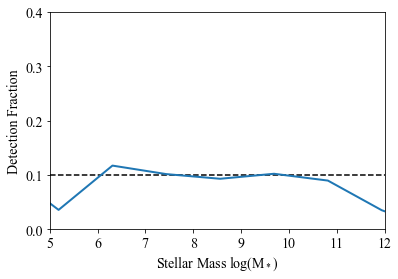

In [604]:
prob = []
hist, bin_edges = np.histogram(stellar_mass_DESSN)
for i in range(len(bin_edges)-1):
    low = bin_edges[i]
    high = bin_edges[i+1]
    ind = np.argwhere((stellar_mass_DESSN>low) & (stellar_mass_DESSN<high))
    if len(ind) == 0:
        prob.append(0)
        continue
    count = 0
    for i in ind:
        if qso[i] > 3 and var[i] > 3:
            count += 1
    prob.append(count/len(ind))
    
print(prob)
plt.hlines(0.1,5,12,linestyles="dashed");
plt.plot(bin_edges[:-1],prob,linewidth=2);
plt.xlabel("Stellar Mass $log(M_*)$");
plt.ylabel("Detection Fraction");
plt.ylim(0,.4);
plt.xlim(5,12);

## Compare Surveys

Compare DES, DES-SN, and LSST surveys:

Generating universe from nsa-like distribution.


/opt/local/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in greater
/opt/local/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in greater


Plotting catalog distributions.
Generating 100000 light curves.
Plotting example AGN light curve.
Generating universe from nsa-like distribution.
Plotting catalog distributions.
Generating 100000 light curves.
Plotting example AGN light curve.


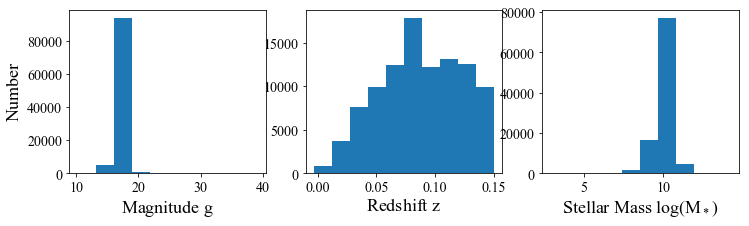

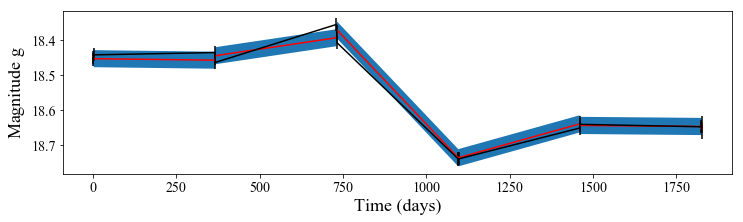

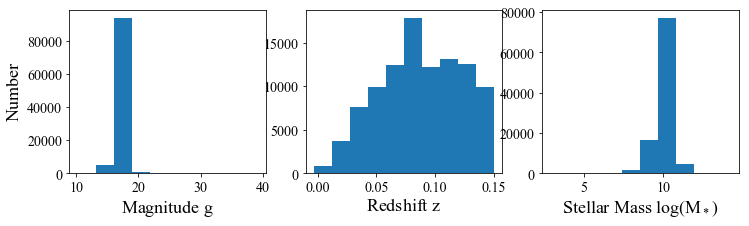

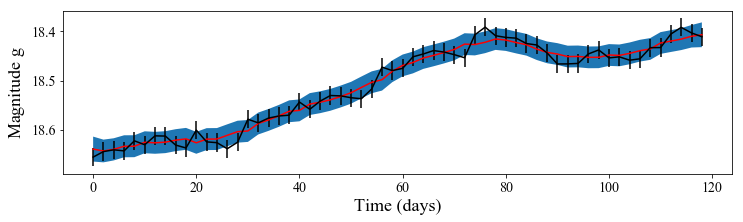

In [614]:
cadence_DES = t_cadence(6,3,1) # DES
cadence_LSST = t_cadence(1,120,2) # LSST

qso_DES, var_DES, not_qso_DES, stellar_mass_DES, agn_DES = ensemble(cadence_DES,distribution="nsa")
qso_LSST, var_LSST, not_qso_LSST, stellar_mass_LSST, agn_LSST = ensemble(cadence_LSST,distribution="nsa")


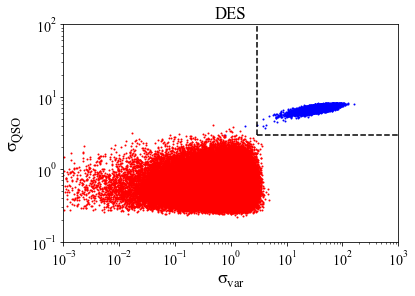

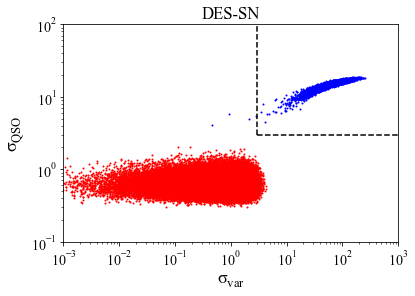

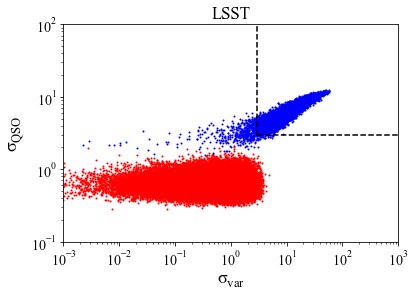

In [616]:
# Compare all 3
plot_metrics(var_DES,qso_DES,"DES")
plot_metrics(var_DESSN,qso_DESSN,"DES-SN")
plot_metrics(var_LSST,qso_LSST,"LSST")